In [51]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-12-31'

EIIE_MODEL = "trained_eiie/policy_EIIE_2018-12-31_3_2024-11-30 00_51_22.pt"

GRAPH_TITLE = "EIIE Trained 2009-2018, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "AMZN",
    "NKE",
    "DIS",
    "JPM",
    "IBM",
    "NVDA",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4536, 8)


# Portfolio Optimization Algorithm

In [52]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.51281211 0.44809312 0.58986465 0.51346091 0.5705164  0.40782923
 0.41803653 0.30102844 0.38580229 0.38532694 0.40899193 0.27036802
 0.38674015 0.41219736 0.3356523  0.26272379 0.31771084 0.31076038
 0.29759817 0.37153521 0.70084729 0.73912625 0.31663166 0.28605474
 0.2530882  0.2971999  0.36342204 0.21309411 0.31210293 0.22870376
 0.26468945 0.27904004 0.23650216 0.21439813 0.22376392 0.19889127
 0.20456341 0.17124357 0.20227014 0.19437539 0.31957372 0.3961766
 0.23648931 0.25669191 0.31842388 0.29979508 0.24900914 0.23218541
 0.22817059 0.18928138 0.48504879 0.34875026 0.40881848 0.4024847
 0.37050741 0.4087414  0.3278539  0.31257187 0.27781311 0.19547385
 0.21331894 0.27228871 0.22149634 0.25220173 0.23278924 0.23385558
 0.24106942 0.23860271 0.19039

In [53]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_26484\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [54]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 6929259.0
Final accumulative portfolio value: 6.929259
Maximum DrawDown: -0.37452738946689523
Sharpe ratio: 1.7633018989800748
Total commission cost: 24596.599601895316


In [55]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2019-03-14
1      1.024062e+06 2019-03-15
2      1.019950e+06 2019-03-18
3      1.055696e+06 2019-03-19
4      1.048281e+06 2019-03-20
..              ...        ...
702    6.829700e+06 2021-12-23
703    6.886325e+06 2021-12-27
704    6.922382e+06 2021-12-28
705    6.918822e+06 2021-12-29
706    6.929259e+06 2021-12-30

[707 rows x 2 columns]


In [56]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2019-03-14 00:00:00
2021-12-30 00:00:00


In [57]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test_split = data_split(processed_test, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test_split,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)



# PPO Model

In [58]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

TRAINED_PPO = "/model_checkpoint_3000000_steps_2018"

test_ppo_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test_split)


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 


environment_ppo = PortfolioOptimizationEnv(
    test_ppo_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.18928138 0.48504879 0.34875026 0.40881848 0.4024847  0.37050741
 0.4087414  0.3278539  0.31257187 0.27781311 0.19547385 0.21331894
 0.27228871 0.22149634 0.25220173 0.23278924 0.23385558 0.24106942
 0.23860271 0.19039911 0.17053696 0.20006038 0.23924508 0.19557663
 0.18587038 0.17664592 0.21672352 0.29808637 0.23612316 0.3917892
 0.54168674 0.25831711 0.22521568 0.2002274  0.25456566 0.40993621
 0.34802438 0.37913447 0.26199791 0.34099041 0.3673084  0.37150951
 0.29736049 0.30143956 0.30241596 0.30426599 0.24398579 0.25727647
 0.18863901 0.28420471 0.21646014 0.20555909 0.27487104 0.20214809
 0.29669885 0.58447515 0.36480957 0.27235294 0.23699036 0.30886538
 0.34501808 0.25969179 0.17204653 0.17959441 0.18315315 0.1692201
 0.25024892 0.18598601 0.20666

Initial portfolio value:1000000
Final portfolio value: 1845837.0
Final accumulative portfolio value: 1.845837
Maximum DrawDown: -0.3362105210416987
Sharpe ratio: 1.0225334710831546
Total commission cost: 22974.732861764147
hit end!
     ppo_opt_net_worth       Date
0          1000000.000 2019-03-14
1          1010260.250 2019-03-15
2          1012916.750 2019-03-18
3          1013829.375 2019-03-19
4          1007505.875 2019-03-20
..                 ...        ...
702        1840936.500 2021-12-23
703        1849082.750 2021-12-27
704        1853804.375 2021-12-28
705        1849181.250 2021-12-29
706        1845837.000 2021-12-30

[707 rows x 2 columns]


# Porfolio Baselines

In [59]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2209474.25
Final accumulative portfolio value: 2.20947425
Maximum DrawDown: -0.3388921826372988
Sharpe ratio: 1.2182837530146204
Total commission cost: 11200.987915333943
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.010110e+06 2019-03-15
2         1.013415e+06 2019-03-18
3         1.016888e+06 2019-03-19
4         1.012377e+06 2019-03-20
..                 ...        ...
702       2.193466e+06 2021-12-23
703       2.213667e+06 2021-12-27
704       2.215560e+06 2021-12-28
705       2.214740e+06 2021-12-29
706       2.209474e+06 2021-12-30

[707 rows x 2 columns]


In [60]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2555493.5
Final accumulative portfolio value: 2.5554935
Maximum DrawDown: -0.3351806177500527
Sharpe ratio: 1.3327634219794413
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0          1000000.000 2019-03-14
1          1010109.625 2019-03-15
2          1013415.750 2019-03-18
3          1017095.625 2019-03-19
4          1012668.500 2019-03-20
..                 ...        ...
702        2548686.750 2021-12-23
703        2604259.500 2021-12-27
704        2584530.250 2021-12-28
705        2573702.250 2021-12-29
706        2555493.500 2021-12-30

[707 rows x 2 columns]


In [61]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1324848.25
Final accumulative portfolio value: 1.32484825
Maximum DrawDown: -0.47916922491695335
Sharpe ratio: 0.4532987990373714
Total commission cost: 766146.683884137
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2019-03-14
1           1.010110e+06 2019-03-15
2           1.003325e+06 2019-03-18
3           1.012642e+06 2019-03-19
4           1.003083e+06 2019-03-20
..                   ...        ...
702         1.321674e+06 2021-12-23
703         1.308245e+06 2021-12-27
704         1.315890e+06 2021-12-28
705         1.331882e+06 2021-12-29
706         1.324848e+06 2021-12-30

[707 rows x 2 columns]


In [62]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 5737667.0
Final accumulative portfolio value: 5.737667
Maximum DrawDown: -0.37554019078582523
Sharpe ratio: 1.6069137622749599
Total commission cost: 24462.739099320257
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.010110e+06 2019-03-15
2         1.003325e+06 2019-03-18
3         1.012642e+06 2019-03-19
4         1.003083e+06 2019-03-20
..                 ...        ...
702       5.748139e+06 2021-12-23
703       6.001220e+06 2021-12-27
704       5.880401e+06 2021-12-28
705       5.818148e+06 2021-12-29
706       5.737667e+06 2021-12-30

[707 rows x 2 columns]


In [63]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 5278816.5
Final accumulative portfolio value: 5.2788165
Maximum DrawDown: -0.3755402891415641
Sharpe ratio: 1.5454960065681276
Total commission cost: 9867.49170569505
hit end!
     bnn_opt_net_worth       Date
0            1000000.0 2019-03-14
1            1000000.0 2019-03-15
2            1000000.0 2019-03-18
3            1000000.0 2019-03-19
4            1000000.0 2019-03-20
..                 ...        ...
702          5288451.0 2021-12-23
703          5521293.0 2021-12-27
704          5410135.5 2021-12-28
705          5352861.5 2021-12-29
706          5278816.5 2021-12-30

[707 rows x 2 columns]


In [64]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_hist_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp_hist = DRLStableAgent(env = environment_benchmarks)
model_scrp_hist = agent_scrp_hist.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp_hist, environment_benchmarks)
SCRP_hist_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_hist_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_hist_opt = pd.DataFrame(SCRP_hist_results["test"]["value"], columns=['scrp_hist_opt_net_worth'])
df_scrp_hist_date = pd.DataFrame(SCRP_hist_results["test"]["date"], columns=['Date'])
if len(df_scrp_hist_opt) == len(df_scrp_hist_date):
    df_scrp_hist_opt['Date'] = df_scrp_hist_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_hist_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_hist_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_hist_opt.loc[len(df_scrp_hist_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (13878, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 5799243.5
Final accumulative portfolio value: 5.7992435
Maximum DrawDown: -0.3410377223290688
Sharpe ratio: 0.8502033734621105
Total commission cost: 16308.656309784856
hit end!
              0           1           2          3          4         5
0      6.695000   27.715315   74.764572  29.156559  13.647305  0.423952
1      6.734500   27.646173   73.861435  29.721327  13.701609  0.430143
2      6.612500   27.499262   73.381638  29.884628  13.618073  0.432894
3      6.500000   27.507904   73.127586  30.476612  13.751725  0.424411
4      6.676000   27.551109   73.861435  30.401760  13.724578  0.425328
...         ...         ...         ...        ...        ...       ...
2308  81.297501  111.752022   98.998993  87.117828  80.263664  3.705536
2309  81.040001  111.555984   98.801529  87.151695  79.830597  3.739796
2310  83.530998  112.477364  100.717728  88.285393  80.790817  4.000468
2311  83.654999  112.457779  101.134613  88.023

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2000282.125
Final accumulative portfolio value: 2.000282125
Maximum DrawDown: -0.22744680165007203
Sharpe ratio: 0.9922951533299245
Total commission cost: 0.04528311372268945
hit end!
     scrp_hist_opt_net_worth       Date
0                1000000.000 2019-03-14
1                1015502.125 2019-03-15
2                1033168.875 2019-03-18
3                1044851.750 2019-03-19
4                1065857.375 2019-03-20
..                       ...        ...
702              2029032.625 2021-12-23
703              2012439.250 2021-12-27
704              2024199.500 2021-12-28
705              2006882.750 2021-12-29
706              2000282.125 2021-12-30

[707 rows x 2 columns]


In [65]:
# SCRP - no history

SCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3158200.75
Final accumulative portfolio value: 3.15820075
Maximum DrawDown: -0.4752674312548322
Sharpe ratio: 1.169271750944473
Total commission cost: 10565.830784655875
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.010110e+06 2019-03-15
2          1.003325e+06 2019-03-18
3          1.012642e+06 2019-03-19
4          1.003083e+06 2019-03-20
..                  ...        ...
702        3.163965e+06 2021-12-23
703        3.303269e+06 2021-12-27
704        3.236766e+06 2021-12-28
705        3.202500e+06 2021-12-29
706        3.158201e+06 2021-12-30

[707 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [66]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 7186727.0
Final accumulative portfolio value: 7.186727
Maximum DrawDown: -0.3755401962394702
Sharpe ratio: 1.7102643134219107
Total commission cost: 0.0
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.025670e+06 2019-03-15
2          1.020476e+06 2019-03-18
3          1.061307e+06 2019-03-19
4          1.053394e+06 2019-03-20
..                  ...        ...
702        7.199844e+06 2021-12-23
703        7.516841e+06 2021-12-27
704        7.365508e+06 2021-12-28
705        7.287534e+06 2021-12-29
706        7.186727e+06 2021-12-30

[707 rows x 2 columns]


# Stock environment optimization algorithm

In [67]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (706, 8)
Annual return          0.133118
Cumulative returns     0.419242
Annual volatility      0.240702
Sharpe ratio           0.641282
Calmar ratio           0.358942
Stability              0.661782
Max drawdown          -0.370862
Omega ratio            1.150808
Sortino ratio          0.883305
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.926766
Daily value at risk   -0.029713
dtype: float64
df_dji:            date           dji
0   2019-03-14  1.000000e+06
1   2019-03-15  1.005404e+06
2   2019-03-18  1.007941e+06
3   2019-03-19  1.006902e+06
4   2019-03-20  1.001390e+06
..         ...           ...
702 2021-12-23  1.398314e+06
703 2021-12-27  1.411998e+06
704 2021-12-28  1.415725e+06
705 2021-12-29  1.419242e+06
706 2021-12-30           NaN

[707 rows x 2 columns]
df_dji:                       dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06

# Compare all results

In [68]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the baseline SCRP hist algorithm
df_scrp_hist_opt['Date'] = pd.to_datetime(df_scrp_hist_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_hist_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06
2019-03-20  1.001390e+06
...                  ...
2021-12-23  1.398314e+06
2021-12-27  1.411998e+06
2021-12-28  1.415725e+06
2021-12-29  1.419242e+06
2021-12-30           NaN

[707 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2019-03-14        1.000000e+06        1000000.000   
1         1.010110e+06 2019-03-15        1.025670e+06        1010109.625   
2         1.013415e+06 2019-03-18        1.020476e+06        1013415.750   
3         1.016888e+06 2019-03-19        1.061307e+06        1017095.625   
4         1.012377e+06 2019-03-20        1.053394e+06        1012668.500   
..                 ...        ...                 ...                ...   
702       2.193466e+06 2021-12-23        7.199844e+06        2548686.750   
703       2.213667e+06 2021-12-27        7.

# Baseline CRP in the environment

In [69]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2019-03-14'
TEST_START_DATE = '2019-03-14'
TEST_END_DATE = '2024-09-01'


TEST_TICKER = [
   "AMZN",
    "NKE",
    "DIS",
    "JPM",
    "IBM",
    "NVDA",
]

TRAINED_PPO = "/agent_opt_ppo_update_test_2019"

GRAPH_TITLE = "PPO Trained 2013-2019, test softmax"

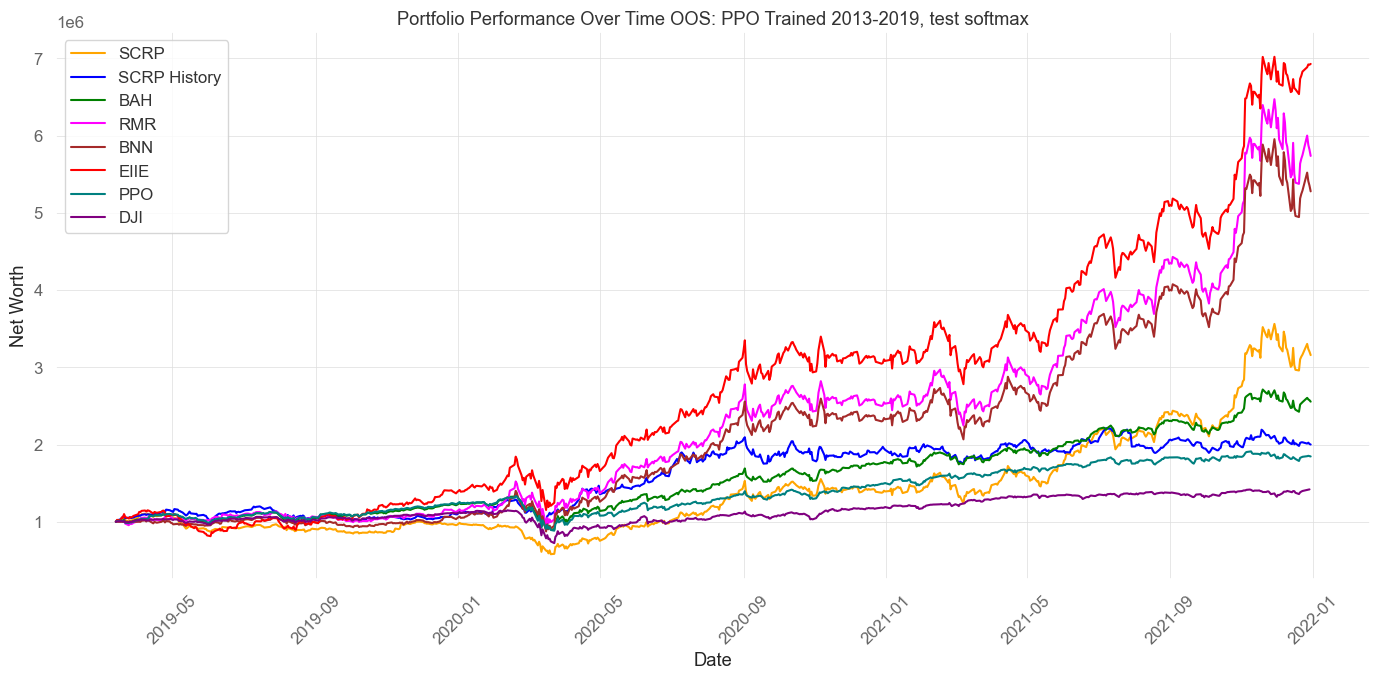

In [70]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BAH': 'green',
    'EIIE': 'red',
    'PPO': 'teal',
    'DJI': 'purple',
    'SCRP': 'orange',
    'SCRP History': 'blue',
    'OLMAR': 'cyan',
    'RMR': 'magenta',
    'BNN': 'brown'
}




plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP', color=color_map['CRP'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP', color=color_map['SCRP'])
plt.plot(merged_df['Date'], merged_df['scrp_hist_opt_net_worth'], label='SCRP History', color=color_map['SCRP History'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH', color=color_map['BAH'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR', color=color_map['OLMAR'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR', color=color_map['RMR'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN', color=color_map['BNN'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE', color=color_map['EIIE'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO', color=color_map['PPO'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI', color=color_map['DJI'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_hist_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
    'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 2555493.5,
 'BCRP OPT': 7186727.0,
 'BNN': 5278816.5,
 'CRP': 2209474.25,
 'EIIE': 6929259.0,
 'Hist. SCRP': 2000282.125,
 'OLMAR': 1324848.25,
 'PPO': 1845837.0,
 'RMR': 5737667.0,
 'SCRP': 3158200.75}


In [72]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()
merged_df['SCRP_hist_opt_daily_return'] = merged_df['scrp_hist_opt_net_worth'].pct_change()


merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['PPO_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_hist_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['PPO_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 1.2625318309917952,
 'BCRP': 1.6697120864205945,
 'BNN': 1.5021301506789135,
 'CRP': 1.142250948678923,
 'EIIE': 1.7200483953128187,
 'Hist. SCRP': 0.9245551699953385,
 'OLMAR': 0.40076526848064264,
 'PPO': 0.9409085560594788,
 'RMR': 1.563778732365836,
 'SCRP': 1.123538140616716}


In [73]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_hist_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.3351806177500527,
 'BCRP': -0.3755401962394702,
 'BNN': -0.3755402891415641,
 'CRP': -0.3388921826372988,
 'EIIE': -0.37452738946689523,
 'Hist. SCRP': -0.22744680165007203,
 'OLMAR': -0.47916922491695335,
 'PPO': -0.3362105210416987,
 'RMR': -0.37554019078582523,
 'SCRP': -0.4752674312548322}


In [74]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_hist_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['PPO_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.5679886685552408,
 'BCRP': 0.5524079320113314,
 'BNN': 0.546742209631728,
 'CRP': 0.5637393767705382,
 'EIIE': 0.556657223796034,
 'Hist. SCRP': 0.5339943342776204,
 'OLMAR': 0.5155807365439093,
 'PPO': 0.5708215297450425,
 'RMR': 0.5580736543909348,
 'SCRP': 0.5396600566572238}


In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.000972     1.0  1.743735  0.186881
Residual   0.785612  1410.0       NaN       NaN


In [76]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.010110
2      0.003273
3      0.003631
4     -0.004353
5      0.011823
         ...   
702    0.005935
703    0.021804
704   -0.007576
705   -0.004190
706   -0.007075
Name: BAH_opt_daily_return, Length: 706, dtype: float64
t-statistic: 1.320505521987894
p-value: 0.1868805906177789
